Necessary imports

In [12]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
import numpy as np
import optuna
from optuna.trial import TrialState
import random
import uncertainty_toolbox as uct



# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':      # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

import utils.NN_model as NN_model
import utils.data_prep as data_prep
import utils.metrices as metrices
import utils.data_prep as set_seed

Load and transform the data

In [13]:
#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = data_prep.load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float() 
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)
print(X_train_tensor.shape, X_val_tensor.shape, X_test_tensor.shape)
print(feature_names)
print(y_train_tensor.shape, y_val_tensor.shape, y_test_tensor.shape)

torch.Size([31206, 37]) torch.Size([10402, 37]) torch.Size([10403, 37])
Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
torch.Size([31206, 1]) torch.Size([10402, 1]) torch.Size([10403, 1])


Hyperparameter Search with Optuna

In [14]:
def objective(trial):
    
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 7)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 64, 640, step=64)  # number of neurons in each hidden layer
    do_rate = trial.suggest_float("do_rate", 0.05, 0.5)     # dropout rate 
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    weight_decay  = trial.suggest_float("wd", 1e-7, 1e-2, log = True)  # weight decay for regularization

    decay = 0.7

    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
    #hidden_dims = [320,224,156]
    #epochs = 1000  # maximum number of epochs for training
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = NN_model.Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=do_rate,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=weight_decay)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = NN_model.heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = NN_model.heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
            
        trial.report(val_loss, step=epoch)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            #print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}, Best Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss


In [15]:
print(f"Using device: {device}")

# number of epochs for training
epochs = 1000

# create a study object for Optuna
study = optuna.create_study(
    #study_name="MC_Dropout_Optuna_Network_architecture",
    #storage="sqlite:///mc_dropout_study.db",                    # Use SQLite database to store the
    #load_if_exists=True,                                        # load the study if it already exists
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=10,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=100, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2025-09-26 20:18:51,077] A new study created in memory with name: no-name-027a9a1d-ae4e-4116-8ca6-1f5d4f08adeb


Using device: cuda


  0%|          | 0/100 [00:00<?, ?it/s]

Hidden dimensions: [512, 358, 250, 175, 122, 86]
Early stopping at epoch 115, Best Val Loss: 2.5962
[I 2025-09-26 20:21:23,458] Trial 0 finished with value: 2.5961968898773193 and parameters: {'n_layer': 6, 'n_neurons': 512, 'do_rate': 0.33061248580106817, 'lr': 0.0002479566652754801, 'batch_size': 128, 'wd': 0.0002890224630436609}. Best is trial 0 with value: 2.5961968898773193.
Hidden dimensions: [576, 403, 282]
Early stopping at epoch 27, Best Val Loss: 3.1144
[I 2025-09-26 20:22:12,625] Trial 1 finished with value: 3.114442825317383 and parameters: {'n_layer': 3, 'n_neurons': 576, 'do_rate': 0.3193759422401593, 'lr': 0.00936707960692485, 'batch_size': 64, 'wd': 0.0003280620793587212}. Best is trial 0 with value: 2.5961968898773193.
Hidden dimensions: [320, 224]
Early stopping at epoch 35, Best Val Loss: 2.2734
[I 2025-09-26 20:23:08,541] Trial 2 finished with value: 2.2733635902404785 and parameters: {'n_layer': 2, 'n_neurons': 320, 'do_rate': 0.1783424501316615, 'lr': 0.0084018208

Train the Model

In [9]:
# selcet Device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
#set_seed(SEED)  # Set the seed for reproducibility
# Move training and val data  to device
X_train_tensor = X_train_tensor.to(device)  
X_val_tensor = X_val_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)
# Create heteroscedastic model instance with best parameters and move to device
model_heteroscedastic = NN_model.Custom_NN_Model(input_dim=X_train.shape[1], hidden_dims=[288,172,104], 
                                                 output_dim=1, do_rate=0.35, 
                                                 loss_type = 'heteroscedastic').to(device)  # Create model instance and move to device
#print(f"Model: {model_heteroscedastic}")
# Train the model with the best parameters
optimizer_heteroscedastic = torch.optim.AdamW(params = model_heteroscedastic.parameters(), lr = 0.005, weight_decay = 1.6717867701815153e-05)  # Use AdamW optimizer with specified learning rate and weight decay
tr_model_heteroscedastic = NN_model.train_model(model_heteroscedastic, X_train_tensor, y_train_tensor, 
                                                X_val_tensor, y_val_tensor, batch_size=128, n_epochs=1000, 
                                                optimizer= optimizer_heteroscedastic, patience=50, 
                                                loss_type='heteroscedastic', device = device)

Using device: cuda
Using device: cuda
Epoch 1/1000, Train Loss: 55.4094, Val Loss: 6.1164, Best Val Loss: 6.1164
Epoch 2/1000, Train Loss: 6.0791, Val Loss: 5.2482, Best Val Loss: 5.2482
Epoch 3/1000, Train Loss: 4.8038, Val Loss: 3.6935, Best Val Loss: 3.6935
Epoch 4/1000, Train Loss: 4.2150, Val Loss: 3.4494, Best Val Loss: 3.4494
Epoch 5/1000, Train Loss: 3.9208, Val Loss: 3.4352, Best Val Loss: 3.4352
Epoch 6/1000, Train Loss: 3.7843, Val Loss: 3.3862, Best Val Loss: 3.3862
Epoch 8/1000, Train Loss: 3.6592, Val Loss: 3.2965, Best Val Loss: 3.2965
Epoch 9/1000, Train Loss: 3.6308, Val Loss: 3.2033, Best Val Loss: 3.2033
Epoch 12/1000, Train Loss: 3.5885, Val Loss: 3.0778, Best Val Loss: 3.0778
Epoch 22/1000, Train Loss: 3.5922, Val Loss: 2.9633, Best Val Loss: 2.9633
Epoch 36/1000, Train Loss: 3.3632, Val Loss: 2.6869, Best Val Loss: 2.6869
Epoch 43/1000, Train Loss: 3.2112, Val Loss: 2.6683, Best Val Loss: 2.6683
Epoch 46/1000, Train Loss: 3.1755, Val Loss: 2.6453, Best Val Loss: 2

Make Predictions

In [10]:
# inference with multiple forward passes
# keep the model in training mode to keep dropout active
tr_model_heteroscedastic.train()
tr_model_heteroscedastic.to('cpu')  # Ensure the model is on the correct device
X_tr = X_train_tensor.to('cpu')  # Ensure the input data is on the correct device
X_te = X_test_tensor.to('cpu')  # Ensure the test data is on the correct device
# Number of stochastic forward passes for MC Dropout
n_samples = 250

# Make multiple stochastic predictions (MC Dropout) on the train data
y_train_pred_heteroscedastic_mean = []
y_train_pred_heteroscedastic_var= []

for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_tr)
    y_train_pred_heteroscedastic_mean.append(mean.detach().numpy())
    y_train_pred_heteroscedastic_var.append(torch.exp(log_var).detach().numpy())

# Make multiple stochastic predictions (MC Dropout) on the test data
y_test_pred_heteroscedastic_mean = []
y_test_pred_heteroscedastic_var = []
for i in range(n_samples):
    mean, log_var = tr_model_heteroscedastic(X_te)
    y_test_pred_heteroscedastic_mean.append(mean.detach().numpy())
    y_test_pred_heteroscedastic_var.append(torch.exp(log_var).detach().numpy())

Epistemic Variance: 3.510464
Aleatoric Variance: 20.743912
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.86it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.81it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.576
  RMSE          3.508
  MDAE          1.933
  MARPD         2.249
  R2            0.784
  Correlation   0.895
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.149
  Mean-absolute Calibration Error       0.135
  Miscalibration Area                   0.136
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.144
     Group Size: 0.56 -- Calibration Error: 0.139
     Group Size: 1.00 -- Calibration Error: 0.135
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.160
     Group Size: 0.56 -- Calibration Error: 0.153
     Group Size: 1.00 -- Calibration Error: 0.149
================

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

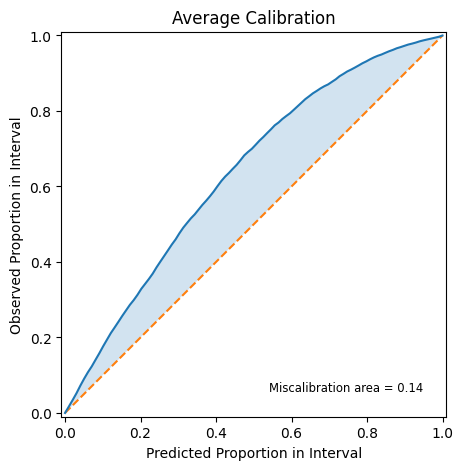

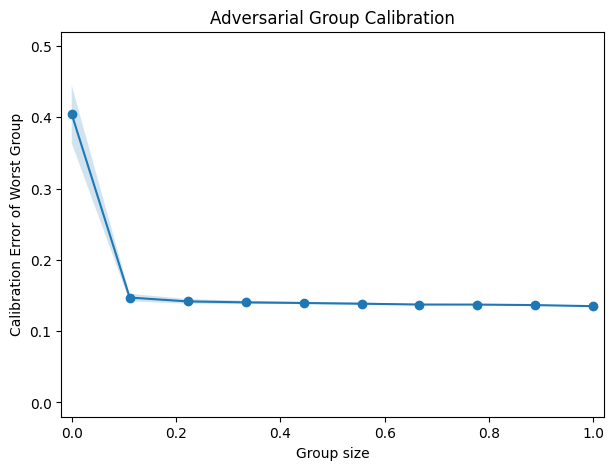

In [11]:
# Calculate the mean and standard deviation of the predictions on the test data
MC_mean = np.mean(y_test_pred_heteroscedastic_mean, axis = 0).reshape(-1)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(y_test_pred_heteroscedastic_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(y_test_pred_heteroscedastic_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
MC_std = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic).reshape(-1)

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics(MC_mean, MC_std, y_test)
print(pnn_metrics)
print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(MC_mean, MC_std, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = metrices.evaluate_intervals(MC_mean, MC_std, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(MC_mean, MC_std, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(MC_mean, MC_std, y_test)

Plotting the data

Shape of y_train_pred_heteroscedastic_mean: (250, 31206, 1)
(31206, 1)
[[113.954185]
 [107.94012 ]
 [121.68198 ]
 [124.85195 ]
 [112.37947 ]]
[114.7258 106.48   121.0372 129.2826 113.5077]
R² on Train Data: 0.865
Epistemic Variance: 2.078640
Aleatoric Variance: 10.550601
Total Standard Deviation: 3.385716
 y_test std: 7.556901454925537
R² on Test Data: 0.845
Shape of mc_lower_bound: (10403,), mc_upper_bound: (10403,)
Number of true values within the confidence interval: 10193 out of 10403
Coverage: 97.98%


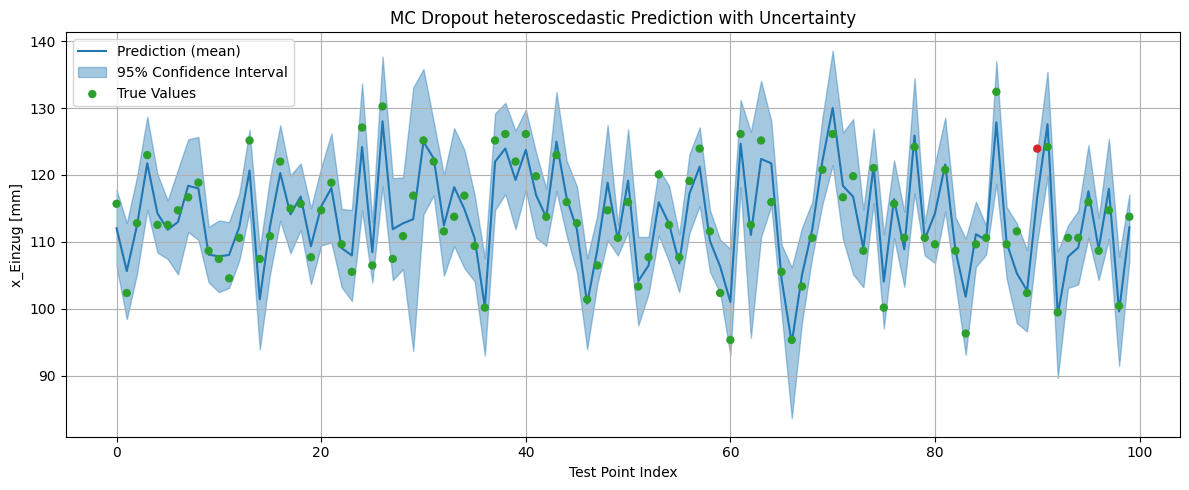

In [ ]:
#! handling the train data
# Calculate the mean of the predictions on the train data
print(f"Shape of y_train_pred_heteroscedastic_mean: {np.array(y_train_pred_heteroscedastic_mean).shape}")
mean_train_pred_heteroscedastic = np.mean(y_train_pred_heteroscedastic_mean, axis=0)  # shape: (31206, 1)
print(mean_train_pred_heteroscedastic.shape)
print(mean_train_pred_heteroscedastic[:5])  # Print first 5 predictions for verification
print(y_train[:5])
# Calculate R² score on the train data
r2_train = r2_score(y_train, mean_train_pred_heteroscedastic)
print(f"R² on Train Data: {r2_train:.3f}")

#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_te), num_points, replace=False)
random_indices.sort()

# Calculate the mean and standard deviation of the predictions on the test data
mean_test_pred_heteroscedastic = np.mean(y_test_pred_heteroscedastic_mean, axis = 0)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(y_test_pred_heteroscedastic_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(y_test_pred_heteroscedastic_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
total_std_heteroscedastic = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic)
print(f"Total Standard Deviation: {total_std_heteroscedastic.mean():.6f}")

print(f' y_test std: {y_test_tensor.std().item()}')

# Calculate R² score for the test data
r2_test = r2_score(y_test_tensor.cpu(), mean_test_pred_heteroscedastic)
print(f"R² on Test Data: {r2_test:.3f}")

# Assign descriptive variable names for MC Dropout mean and standard deviation
mc_mean = mean_test_pred_heteroscedastic  # Predicted mean for each test point
mc_std = total_std_heteroscedastic    # Predicted standard deviation for uncertainty

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
mc_lower_bound = (mc_mean - 2 * mc_std).reshape(-1)  # Ensure it is a 1D array
mc_upper_bound = (mc_mean+ 2 * mc_std).reshape(-1)  # Ensure it is a 1D array

print(f"Shape of mc_lower_bound: {mc_lower_bound.shape}, mc_upper_bound: {mc_upper_bound.shape}")

# calculate the coverage of the confidence interval
in_interval = (y_test >= mc_lower_bound) & (y_test <= mc_upper_bound)
# number of true
counter = 0
# Print whether each true value is within the confidence interval
for i in in_interval:
    if i:
        counter += 1

print(f"Number of true values within the confidence interval: {counter} out of {len(in_interval)}")

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Check whether each true value from random indices lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval_rand_indi = (y_test[random_indices] >= mc_lower_bound[random_indices]) & (y_test[random_indices] <= mc_upper_bound[random_indices])
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval_rand_indi]

# Create the plot
plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)  # Create an index axis for plotting

# Plot the predicted mean
plt.plot(x_axis, mc_mean[random_indices], label="Prediction (mean)", color='tab:blue')

# Plot the confidence interval as a shaded region
plt.fill_between(x_axis, mc_lower_bound[random_indices], mc_upper_bound[random_indices], alpha=0.4,
                 color='tab:blue', label='95% Confidence Interval')

# Scatter plot of true values with color-coded points based on interval inclusion
plt.scatter(x_axis, y_test_tensor[random_indices].cpu().flatten(), label="True Values", c=colors, s=25, zorder=3)

# Final plot settings
plt.title("MC Dropout heteroscedastic Prediction with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()